In [20]:
import pandas as pd
import numpy as np
import os


In [21]:
print(os.listdir("../data"))


['legitimate_urls.csv', '.DS_Store', 'phishing_urls.csv', 'final_dataset.csv']


In [22]:
legit_raw = pd.read_csv("../data/legitimate_urls.csv")
phish_raw = pd.read_csv("../data/phishing_urls.csv")

print("Legit columns:", legit_raw.columns)
print("Phish columns:", phish_raw.columns)


Legit columns: Index(['Unnamed: 0', 'website_url', 'cleaned_website_text', 'Category'], dtype='str')
Phish columns: Index(['phish_id', 'url', 'phish_detail_url', 'submission_time', 'verified',
       'verification_time', 'online', 'target'],
      dtype='str')


In [24]:
# Keep ONLY the URL column (correct column name)
legit = legit_raw[['website_url']].copy()

# Rename to standard name
legit.columns = ['url']

# Add label (0 = legitimate)
legit['label'] = 0

# Remove nulls & duplicates
legit.dropna(inplace=True)
legit.drop_duplicates(inplace=True)

print("Legitimate URLs:", legit.shape)
legit.head()


Legitimate URLs: (1384, 2)


,url,label
0,https://www.booking.com/index.html?aid=1743217,0
1,https://travelsites.com/expedia/,0
2,https://travelsites.com/tripadvisor/,0
3,https://www.momondo.in/?ispredir=true,0
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,0


In [25]:
# Keep ONLY phishing URLs (real fake sites)
phish = phish_raw[['url']].copy()

# Add label
phish['label'] = 1

# Remove duplicates & nulls
phish.dropna(inplace=True)
phish.drop_duplicates(inplace=True)

print("Phishing URLs:", phish.shape)
phish.head()


Phishing URLs: (52809, 2)


,url,label
0,https://cozy-baklava-ee96f6.netlify.app/indexs...,1
1,https://l.ead.me/bga9PZ,1
2,https://l.ead.me/bgahOB,1
3,https://l.ead.me/bgawCI,1
4,https://l.ead.me/bgax1Q,1


In [26]:
min_size = min(len(legit), len(phish))

legit_bal = legit.sample(min_size, random_state=42)
phish_bal = phish.sample(min_size, random_state=42)

data = pd.concat([legit_bal, phish_bal])
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print("Final dataset shape:", data.shape)
data.head()


Final dataset shape: (2768, 2)


,url,label
0,http://www.wageningenur.nl/en/Expertise-Servic...,0
1,https://www.theworldwomennews.com/,0
2,https://ow.ly/9KPv50Rqj4B,1
3,https://cherished-transform-893212.framer.app,1
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,0


In [27]:
data.to_csv("../data/final_dataset.csv", index=False)


In [28]:
import re, math
from urllib.parse import urlparse

def url_entropy(url):
    probs = [url.count(c)/len(url) for c in set(url)]
    return -sum(p * math.log2(p) for p in probs)

def extract_url_features(url):
    return {
        "url_length": len(url),
        "dot_count": url.count("."),
        "has_ip": int(bool(re.search(r'\d+\.\d+\.\d+\.\d+', url))),
        "has_https": int(url.startswith("https")),
        "has_hyphen": int("-" in urlparse(url).netloc),
        "keyword_count": sum(w in url.lower() for w in ["login","verify","secure","update","bank"]),
        "entropy": url_entropy(url)
    }


In [29]:
import requests
from bs4 import BeautifulSoup

def extract_content_features(url):
    features = {
        "has_form": 0,
        "has_password": 0,
        "external_links": 0,
        "urgency_words": 0
    }
    try:
        r = requests.get(url, timeout=5)
        soup = BeautifulSoup(r.text, "html.parser")

        features["has_form"] = int(bool(soup.find("form")))
        features["has_password"] = int(bool(soup.find("input", {"type":"password"})))
        features["external_links"] = len(soup.find_all("a", href=True))
        text = soup.get_text().lower()
        features["urgency_words"] = sum(w in text for w in ["urgent","verify","blocked"])
    except:
        pass

    return features


In [30]:
rows = []

for _, row in data.iterrows():
    f = extract_url_features(row['url'])
    f.update(extract_content_features(row['url']))
    f['label'] = row['label']
    rows.append(f)

df = pd.DataFrame(rows)
df.head()


,url_length,dot_count,has_ip,has_https,has_hyphen,keyword_count,entropy,has_form,has_password,external_links,urgency_words,label
0,113,3,0,0,0,0,4.578096,0,0,0,0,0
1,34,2,0,1,0,0,3.777777,0,0,4,0,0
2,25,1,0,1,0,0,4.373661,0,0,103,0,1
3,45,2,0,1,1,0,4.333209,0,0,0,0,1
4,127,5,0,1,0,0,5.286425,0,0,1,0,0


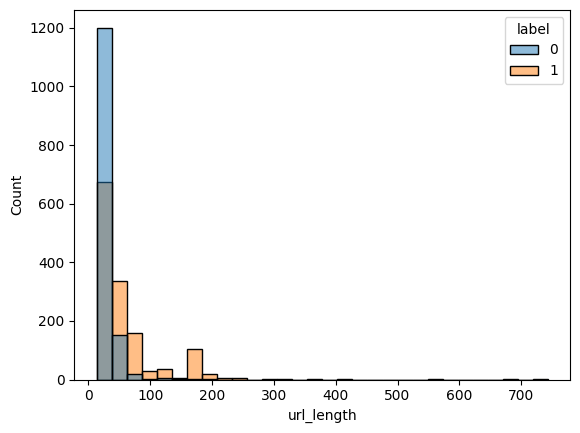

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df, x="url_length", hue="label", bins=30)
plt.show()


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.85      0.81      0.83       277
           1       0.82      0.86      0.84       277

    accuracy                           0.83       554
   macro avg       0.83      0.83      0.83       554
weighted avg       0.83      0.83      0.83       554



In [33]:
import joblib
joblib.dump(model, "../src/phish_model.pkl")


['../src/phish_model.pkl']